# EDA Notebook for Plots/Charts
---
## 1. Exploring the Central Park Weather Dataset

I want to examine whether this dataset has a positive impact on the predictive model. I will start by performing some EDA and then add these features to the base model (modeling done in the main notebook, this one is for exploring relationships with weather data added)

In [1]:
# Imports
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import xgboost as xgb
plt.rcParams['figure.figsize'] = [16, 10]

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV
from xgboost import XGBClassifier, XGBRegressor

In [2]:
# Tells pandas what format my datetime features are in for faster parsing of csv
dateparse = lambda x: pd.datetime.strptime(x, '%d-%m-%Y')
wdf = pd.read_csv("../input/weather-data-in-new-york-city-2016/weather_data_nyc_centralpark_2016.csv", 
                 parse_dates=['date'], date_parser=dateparse)
df = pd.read_csv('../input/nyc-taxi-trip-duration/train.csv')
test = pd.read_csv('../input/nyc-taxi-trip-duration/test.csv')

In [3]:
# Converting taxi data to datetime
df.pickup_datetime = pd.to_datetime(df.pickup_datetime)
test.pickup_datetime = pd.to_datetime(test.pickup_datetime)
df.dropoff_datetime = pd.to_datetime(df.dropoff_datetime)

### Description of Central Park Weather Data

Weather data collected from the National Weather Service. It contains the first six months of 2016, for a weather station in central park. It contains for each day the minimum temperature, maximum temperature, average temperature, precipitation, new snow fall, and current snow depth. The temperature is measured in Fahrenheit and the depth is measured in inches. T means that there is a trace of precipitation. I will impute this value to 0.25 inches so you can barely see it register on a plot but the exact value is not agreed upon.

**Key**
    - df = training taxi data from Kaggle
    - wdf (weather df) = central park weather data

In [4]:
wdf.head()

,date,maximum temerature,minimum temperature,average temperature,precipitation,snow fall,snow depth
0,2016-01-01,42,34,38.0,0.00,0.0,0
1,2016-01-02,40,32,36.0,0.00,0.0,0
2,2016-01-03,45,35,40.0,0.00,0.0,0
3,2016-01-04,36,14,25.0,0.00,0.0,0
4,2016-01-05,29,11,20.0,0.00,0.0,0


In [5]:
wdf.dtypes

date                   datetime64[ns]
maximum temerature              int64
minimum temperature             int64
average temperature           float64
precipitation                  object
snow fall                      object
snow depth                     object
dtype: object

In [6]:
start_date = '2016-01-01'
end_date = '2016-07-01'

In [7]:
mask = (wdf['date'] >= start_date) & (wdf['date'] <= end_date)

In [8]:
wdf = wdf.loc[mask]

In [9]:
wdf.tail()

,date,maximum temerature,minimum temperature,average temperature,precipitation,snow fall,snow depth
178,2016-06-27,83,67,75.0,0.45,0.0,0
179,2016-06-28,76,68,72.0,0.12,0.0,0
180,2016-06-29,83,67,75.0,0.01,0.0,0
181,2016-06-30,85,67,76.0,0.00,0.0,0
182,2016-07-01,79,66,72.5,0.83,0,0


In [10]:
wdf.columns = ['date', 'max_temp', 'min_temp', 'avg_temp', 'precip', 'snow_fall', 'snow_depth']

In [11]:
wdf.head()

,date,max_temp,min_temp,avg_temp,precip,snow_fall,snow_depth
0,2016-01-01,42,34,38.0,0.00,0.0,0
1,2016-01-02,40,32,36.0,0.00,0.0,0
2,2016-01-03,45,35,40.0,0.00,0.0,0
3,2016-01-04,36,14,25.0,0.00,0.0,0
4,2016-01-05,29,11,20.0,0.00,0.0,0


In [12]:
# Get datetime features for original taxi data
df.pickup_datetime  = pd.to_datetime(df.pickup_datetime)
df.dropoff_datetime = pd.to_datetime(df.dropoff_datetime)
df['pickup_hour']   = df.pickup_datetime.dt.hour
df['day_of_year']   = df.pickup_datetime.dt.dayofyear
df['day_of_week']   = df.pickup_datetime.dt.dayofweek

In [13]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_hour,day_of_year,day_of_week
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,17,74,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,0,164,6
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,11,19,1
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,19,97,2
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,13,86,5


In [14]:
# Change T (trace) of precipitation to 0.25 inches 
wdf['snow_fall']   = [0.25 if c=='T' else float(c) for c in wdf['snow_fall']]
wdf['snow_depth']  = [0.25 if c=='T' else float(c) for c in wdf['snow_depth']]
wdf['precip']      = [0.25 if c=='T' else float(c) for c in wdf['precip']]
wdf['day_of_year'] = wdf.date.dt.dayofyear

In [15]:
wdf.dtypes

date           datetime64[ns]
max_temp                int64
min_temp                int64
avg_temp              float64
precip                float64
snow_fall             float64
snow_depth            float64
day_of_year             int64
dtype: object

In [16]:
# Check day_of_year before merging
wdf.head()

,date,max_temp,min_temp,avg_temp,precip,snow_fall,snow_depth,day_of_year
0,2016-01-01,42,34,38.0,0.0,0.0,0.0,1
1,2016-01-02,40,32,36.0,0.0,0.0,0.0,2
2,2016-01-03,45,35,40.0,0.0,0.0,0.0,3
3,2016-01-04,36,14,25.0,0.0,0.0,0.0,4
4,2016-01-05,29,11,20.0,0.0,0.0,0.0,5


In [17]:
# Check day_of_year before merging
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_hour,day_of_year,day_of_week
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,17,74,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,0,164,6
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,11,19,1
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,19,97,2
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,13,86,5


In [18]:
df = pd.merge(df,wdf,on='day_of_year')
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_hour,day_of_year,day_of_week,date,max_temp,min_temp,avg_temp,precip,snow_fall,snow_depth
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,17,74,0,2016-03-14,51,40,45.5,0.29,0.0,0.0
1,id2129090,1,2016-03-14 14:05:39,2016-03-14 14:28:05,1,-73.975090,40.758766,-73.953201,40.765068,N,...,14,74,0,2016-03-14,51,40,45.5,0.29,0.0,0.0
2,id0256505,1,2016-03-14 15:04:38,2016-03-14 15:16:13,1,-73.994484,40.745087,-73.998993,40.722710,N,...,15,74,0,2016-03-14,51,40,45.5,0.29,0.0,0.0
3,id3863815,2,2016-03-14 04:24:36,2016-03-14 04:37:11,3,-73.944359,40.714489,-73.910530,40.709492,N,...,4,74,0,2016-03-14,51,40,45.5,0.29,0.0,0.0
4,id3817493,2,2016-03-14 14:57:56,2016-03-14 15:15:26,1,-73.952881,40.766468,-73.978630,40.761921,N,...,14,74,0,2016-03-14,51,40,45.5,0.29,0.0,0.0


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1458644 entries, 0 to 1458643
Data columns (total 21 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null datetime64[ns]
dropoff_datetime      1458644 non-null datetime64[ns]
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
pickup_hour           1458644 non-null int64
day_of_year           1458644 non-null int64
day_of_week           1458644 non-null int64
date                  1458644 non-null datetime64[ns]
max_temp              1458644 non-null int64
min_temp              1458644 non-null int64
avg_temp              1458644 non-null float64
precip                1458644 non-null

## 2. Feature Extraction (from main notebook)

**NOTE**: The following code was pulled from the main notebook and goes through the feature extraction steps in order to make  EDA plots in the latter part of this notebook

In [20]:
coords = np.vstack((df[['pickup_latitude', 'pickup_longitude']].values,
                    df[['dropoff_latitude', 'dropoff_longitude']].values,
                    test[['pickup_latitude', 'pickup_longitude']].values,
                    test[['dropoff_latitude', 'dropoff_longitude']].values))

pca = PCA().fit(coords)
df['pickup_pca0'] = pca.transform(df[['pickup_latitude', 'pickup_longitude']])[:, 0]
df['pickup_pca1'] = pca.transform(df[['pickup_latitude', 'pickup_longitude']])[:, 1]
df['dropoff_pca0'] = pca.transform(df[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
df['dropoff_pca1'] = pca.transform(df[['dropoff_latitude', 'dropoff_longitude']])[:, 1]

test['pickup_pca0'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 0]
test['pickup_pca1'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 1]
test['dropoff_pca0'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
test['dropoff_pca1'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:, 1]

In [21]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [22]:
df['distance_haversine'] = haversine_array(df['pickup_latitude'].values, 
                                              df['pickup_longitude'].values, 
                                              df['dropoff_latitude'].values, 
                                              df['dropoff_longitude'].values)

df['distance_dummy_manhattan'] = dummy_manhattan_distance(df['pickup_latitude'].values, 
                                                             df['pickup_longitude'].values, 
                                                             df['dropoff_latitude'].values, 
                                                             df['dropoff_longitude'].values)

df['direction'] = bearing_array(df['pickup_latitude'].values, 
                                   df['pickup_longitude'].values, 
                                   df['dropoff_latitude'].values, 
                                   df['dropoff_longitude'].values)

df['pca_manhattan'] = np.abs(df['dropoff_pca1'] - df['pickup_pca1']) + np.abs(df['dropoff_pca0'] - df['pickup_pca0'])

test['distance_haversine'] = haversine_array(test['pickup_latitude'].values,
                                             test['pickup_longitude'].values, 
                                             test['dropoff_latitude'].values, 
                                             test['dropoff_longitude'].values)

test['distance_dummy_manhattan'] = dummy_manhattan_distance(test['pickup_latitude'].values,
                                                            test['pickup_longitude'].values, 
                                                            test['dropoff_latitude'].values,
                                                            test['dropoff_longitude'].values)

test['direction'] = bearing_array(test['pickup_latitude'].values,
                                  test['pickup_longitude'].values, 
                                  test['dropoff_latitude'].values, 
                                  test['dropoff_longitude'].values)

test['pca_manhattan'] = np.abs(test['dropoff_pca1'] - test['pickup_pca1']) + np.abs(test['dropoff_pca0'] - test['pickup_pca0'])

df['center_latitude'] = (df['pickup_latitude'].values + df['dropoff_latitude'].values) / 2
df['center_longitude'] = (df['pickup_longitude'].values + df['dropoff_longitude'].values) / 2
test['center_latitude'] = (test['pickup_latitude'].values + test['dropoff_latitude'].values) / 2
test['center_longitude'] = (test['pickup_longitude'].values + test['dropoff_longitude'].values) / 2

In [23]:
df['pickup_weekday'] = df['pickup_datetime'].dt.weekday
df['pickup_weekday_name'] = df['pickup_datetime'].dt.weekday_name
df['pickup_hour_dayofyear'] = df['pickup_datetime'].dt.dayofyear
df['pickup_hour_weekofyear'] = df['pickup_datetime'].dt.weekofyear
df['pickup_month'] = df['pickup_datetime'].dt.month
df['pickup_hour'] = df['pickup_datetime'].dt.hour
df['pickup_minute'] = df['pickup_datetime'].dt.minute
df['pickup_dt'] = (df['pickup_datetime'] - df['pickup_datetime'].min()).dt.total_seconds()
df['pickup_date'] = df['pickup_datetime'].dt.date
df['pickup_week_hour'] = df['pickup_weekday'] * 24 + df['pickup_hour']

test['pickup_weekday'] = test['pickup_datetime'].dt.weekday
test['pickup_weekday_name'] = test['pickup_datetime'].dt.weekday_name
test['pickup_hour_dayofyear'] = test['pickup_datetime'].dt.dayofyear
test['pickup_hour_weekofyear'] = test['pickup_datetime'].dt.weekofyear
test['pickup_month'] = test['pickup_datetime'].dt.month
test['pickup_hour'] = test['pickup_datetime'].dt.hour
test['pickup_minute'] = test['pickup_datetime'].dt.minute
test['pickup_dt'] = (test['pickup_datetime'] - df['pickup_datetime'].min()).dt.total_seconds()
test['pickup_date'] = test['pickup_datetime'].dt.date
test['pickup_week_hour'] = test['pickup_weekday'] * 24 + df['pickup_hour']

In [24]:
df['avg_speed_h'] = 1000 * df['distance_haversine'] / df['trip_duration']
df['avg_speed_m'] = 1000 * df['distance_dummy_manhattan'] / df['trip_duration']

## 3. Plots

In [25]:
df.pickup_weekday.value_counts()

4    223533
5    220868
3    218574
2    210136
1    202749
6    195366
0    187418
Name: pickup_weekday, dtype: int64

In [26]:
df.pickup_weekday_name.value_counts()

Friday       223533
Saturday     220868
Thursday     218574
Wednesday    210136
Tuesday      202749
Sunday       195366
Monday       187418
Name: pickup_weekday_name, dtype: int64

* Key:
    - 0 = Monday
    - 1 = Tuesday 
    - ...
    - 6 = Sunday

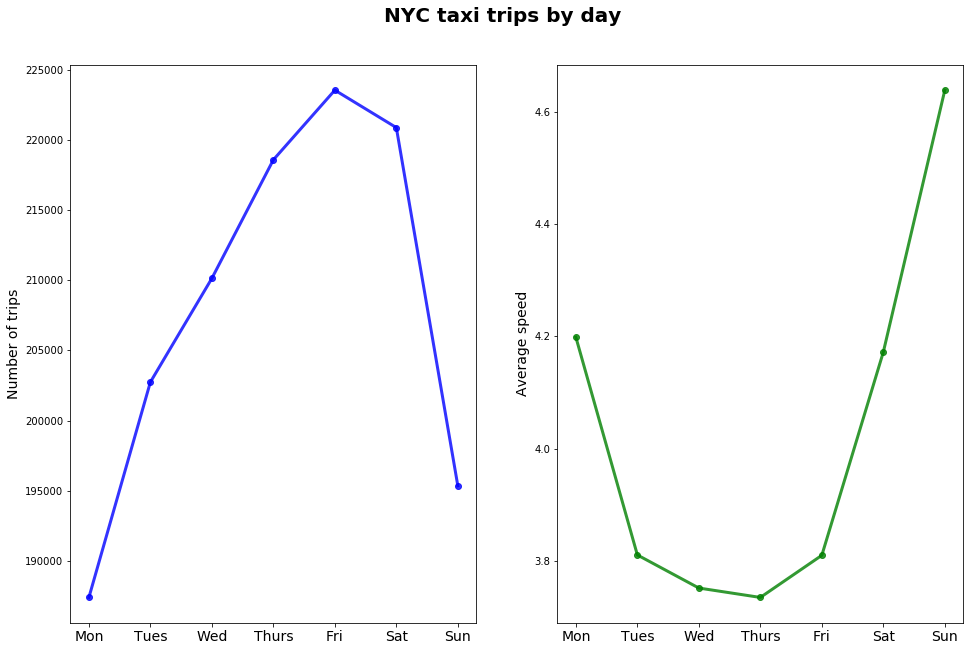

In [27]:
fig, ax = plt.subplots(ncols=2)
ax[0].plot(df.groupby('pickup_weekday').count()[['id']], 'bo-', lw=3, alpha=0.8, label='trips')
ax[1].plot(df.groupby('pickup_weekday').mean()['avg_speed_h'], 'go-', lw=3, alpha=0.8, label='speed')
labels = ['dummy-label,','Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
ax[0].set_xticklabels(labels, fontsize=14)
ax[1].set_xticklabels(labels, fontsize=14)
ax[0].set_ylabel('Number of trips', fontsize=14)
ax[1].set_ylabel('Average speed', fontsize=14)
fig.suptitle('NYC taxi trips by day', fontsize=20, fontweight='bold')
fig.subplots_adjust(top=0.9)
plt.show()

* Why weekends have most total cab rides
    - Partly: "New week resolution"--> people saying "screw it ill take a cab" as week goes on
    - Another: social life, people go out on Fridays, Saturdays... tend to travel far and are drinking... would rather take a cab than subway
* Why traffic is highest during the weekdays
    - People are traveling to and from work and as more people take cabs towards the end of the week, traffic gets heavier
    - Traffic is lightest on Sundays

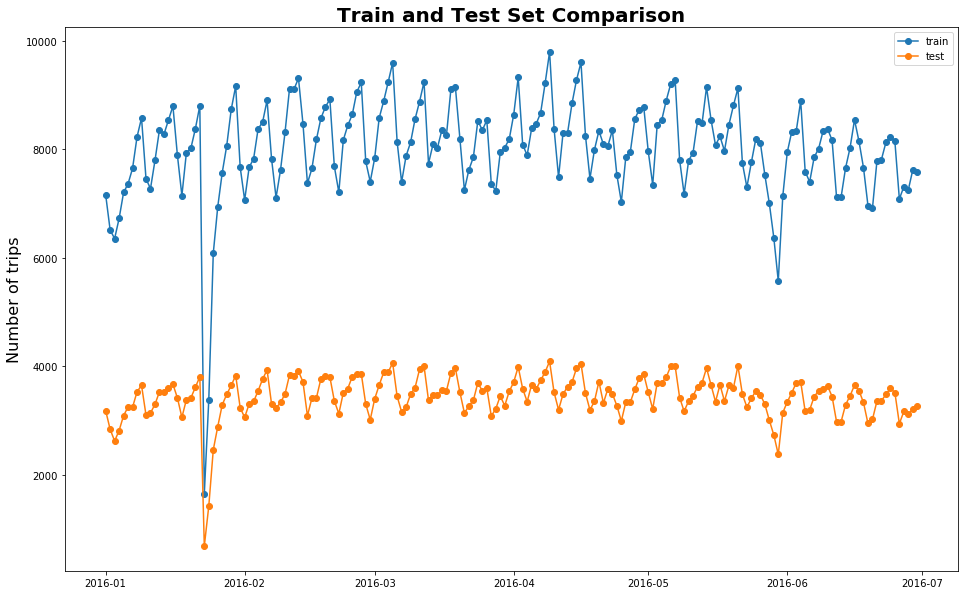

In [28]:
plt.plot(df.groupby('pickup_date').count()[['id']], 'o-', label='train')
plt.plot(test.groupby('pickup_date').count()[['id']], 'o-', label='test')
plt.title('Train and Test Set Comparison', fontsize=20, fontweight='bold')
plt.legend(loc=0)
plt.ylabel('Number of trips', fontsize=16)
plt.show()

* Observations:
    - Comparison of train and test sets in respect to number of trips
    - We can see that they are a perfect overlap and can conclude they were randomly split
    - From a quick glance I notice 3 dips in number of trips... More on this to come

## 4. Plotting NYC by Neighborhood Cluster

In [29]:
# Setting latitude/longitude limits to focus on NYC
xlim = [-74.03, -73.77]
ylim = [40.63, 40.85]
df = df[(df.pickup_longitude> xlim[0]) & (df.pickup_longitude < xlim[1])]
df = df[(df.dropoff_longitude> xlim[0]) & (df.dropoff_longitude < xlim[1])]
df = df[(df.pickup_latitude> ylim[0]) & (df.pickup_latitude < ylim[1])]
df = df[(df.dropoff_latitude> ylim[0]) & (df.dropoff_latitude < ylim[1])]

In [30]:
# Combining pickup/dropoff lats and longs
longitude = list(df.pickup_longitude) + list(df.dropoff_longitude)
latitude = list(df.pickup_latitude) + list(df.dropoff_latitude)

In [31]:
# Make list of lats/longs into a df
loc_df = pd.DataFrame()
loc_df['longitude'] = longitude
loc_df['latitude'] = latitude

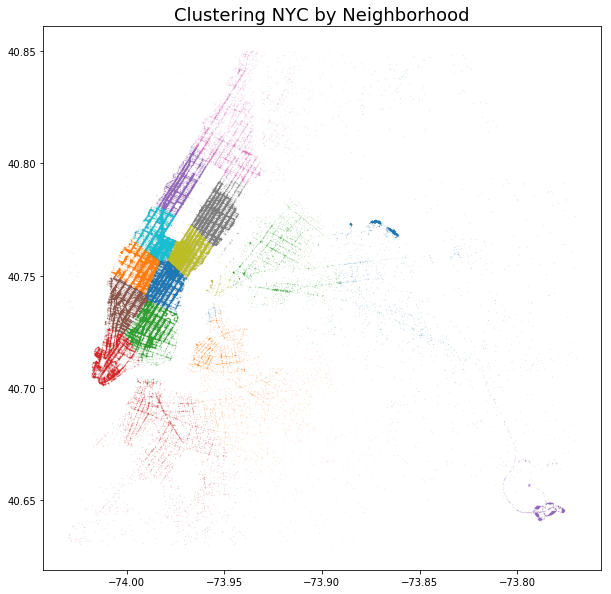

In [32]:
# Cluster and plot
kmeans = KMeans(n_clusters=15, random_state=2, n_init = 10).fit(loc_df)
loc_df['label'] = kmeans.labels_

loc_df = loc_df.sample(200000)
plt.figure(figsize = (10,10))
for label in loc_df.label.unique():
    plt.plot(loc_df.longitude[loc_df.label == label],
             loc_df.latitude[loc_df.label == label],
             '.', alpha = 0.3, markersize = 0.3)

plt.title('Clustering NYC by Neighborhood', fontsize=18)
plt.show()

**Neighborhood clusters**:

As we can see, the clustering results in a partition which is somewhat similar to the way NYC is divided into different neighborhoods. We can see Upper East and West side of Central park in gray and pink respectively. West midtown in blue, Chelsea and West Village in brown, downtown area in blue, East Village and SoHo in purple.

The airports JFK and La LaGuardia have their own cluster, and so do Queens and Harlem. Brooklyn is divided into 2 clusters, and the Bronx has too few rides to be separated from Harlem. 

**Edit**: I realized that the colors change everytime you rereun the clustering so the above description may be misleading but the neighborhoods stay the same. Also, you can change the number of clusters but 15 seems to do the trick and describe most of the neighborhoods in Manhattan

## 5. Weather Plots

In [33]:
wdf.head()

,date,max_temp,min_temp,avg_temp,precip,snow_fall,snow_depth,day_of_year
0,2016-01-01,42,34,38.0,0.0,0.0,0.0,1
1,2016-01-02,40,32,36.0,0.0,0.0,0.0,2
2,2016-01-03,45,35,40.0,0.0,0.0,0.0,3
3,2016-01-04,36,14,25.0,0.0,0.0,0.0,4
4,2016-01-05,29,11,20.0,0.0,0.0,0.0,5


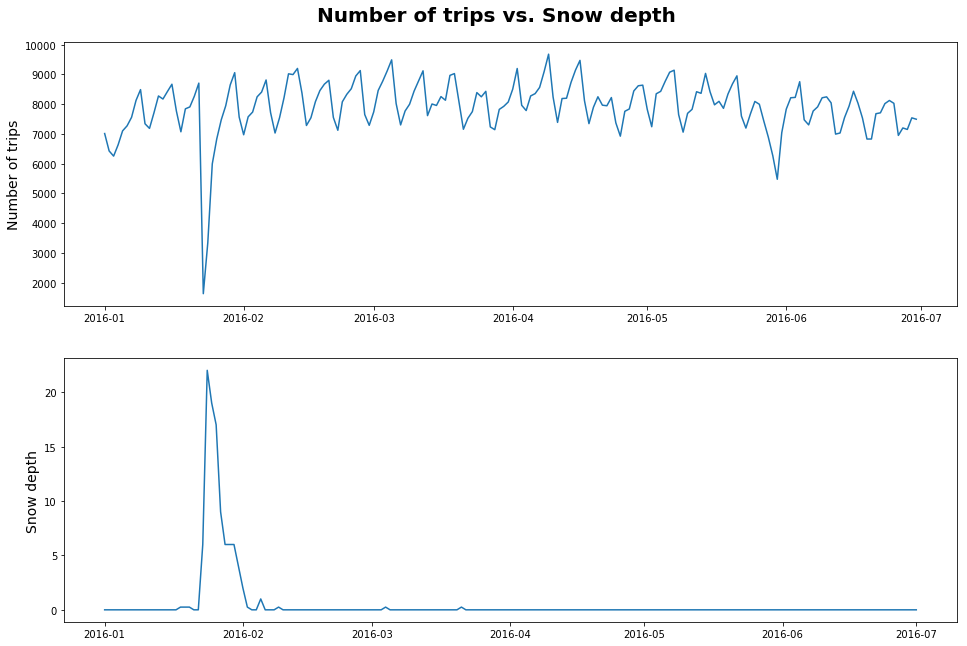

In [34]:
plt.suptitle('Number of trips vs. Snow depth', fontsize=20, fontweight='bold')
plt.subplot(211)
plt.plot(df.groupby('pickup_date').count()[['id']])
plt.ylabel('Number of trips',fontsize = 14)

plt.subplot(212)
plt.plot(wdf.groupby('date').mean()[['snow_depth']])
plt.ylabel('Snow depth',fontsize = 14)
plt.subplots_adjust(top=0.93)
plt.show()

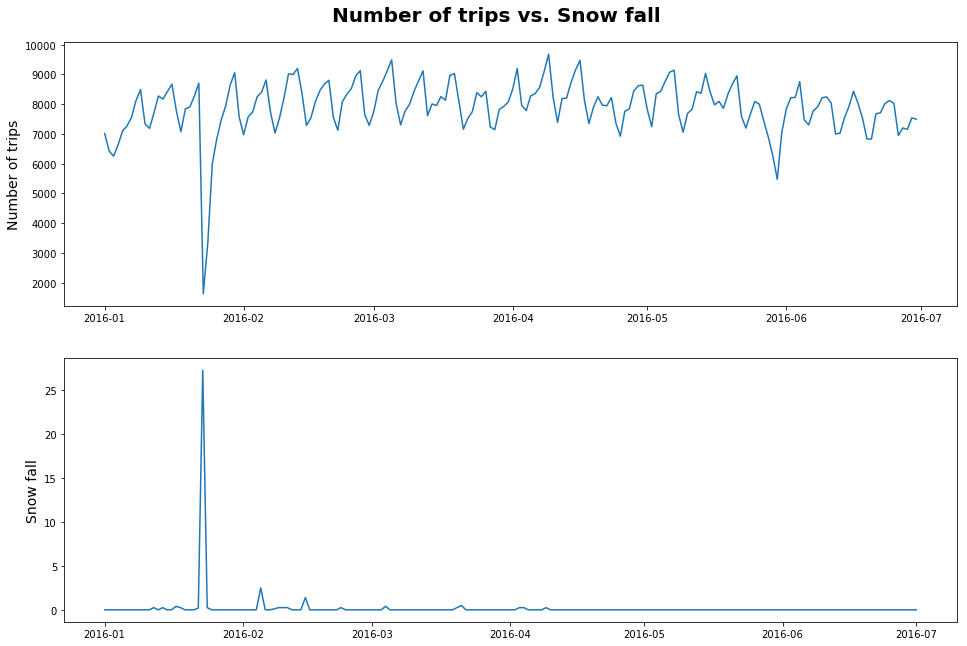

In [35]:
plt.suptitle('Number of trips vs. Snow fall', fontsize=20, fontweight='bold')
plt.subplot(211)
plt.plot(df.groupby('pickup_date').count()[['id']])
plt.ylabel('Number of trips',fontsize = 14)

plt.subplot(212)
plt.plot(wdf.groupby('date').mean()[['snow_fall']])
plt.ylabel('Snow fall',fontsize = 14)
plt.subplots_adjust(top=0.93)
plt.show()

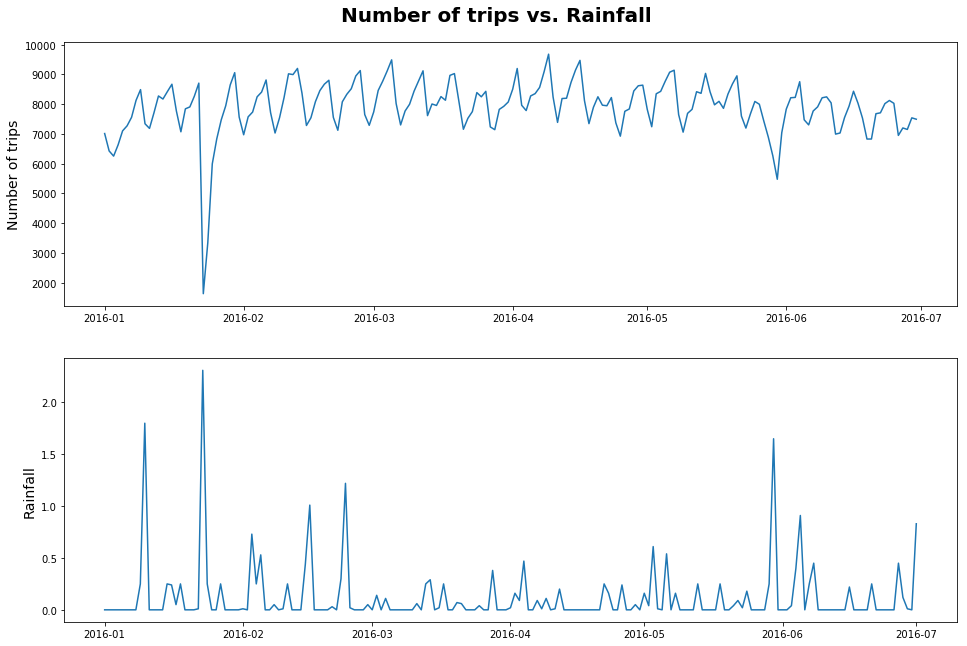

In [36]:
plt.suptitle('Number of trips vs. Rainfall', fontsize=20, fontweight='bold')
plt.subplot(211)
plt.plot(df.groupby('pickup_date').count()[['id']])
plt.ylabel('Number of trips',fontsize = 14)

plt.subplot(212)
plt.plot(wdf.groupby('date').mean()[['precip']])
plt.ylabel('Rainfall',fontsize = 14)
plt.subplots_adjust(top=0.93)
plt.show()

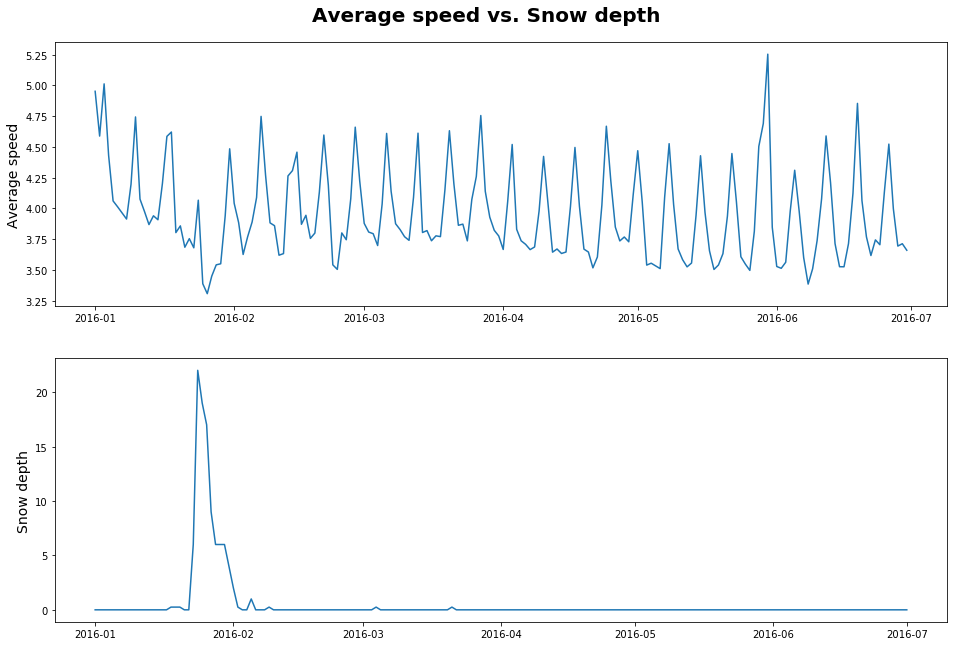

In [37]:
plt.suptitle('Average speed vs. Snow depth', fontsize=20, fontweight='bold')
plt.subplot(211)
plt.plot(df.groupby('pickup_date').mean()[['avg_speed_h']])
plt.ylabel('Average speed', fontsize = 14)

plt.subplot(212)
plt.plot(wdf.groupby('date').mean()[['snow_depth']])
plt.ylabel('Snow depth',fontsize = 14)
plt.subplots_adjust(top=0.93)
plt.show()

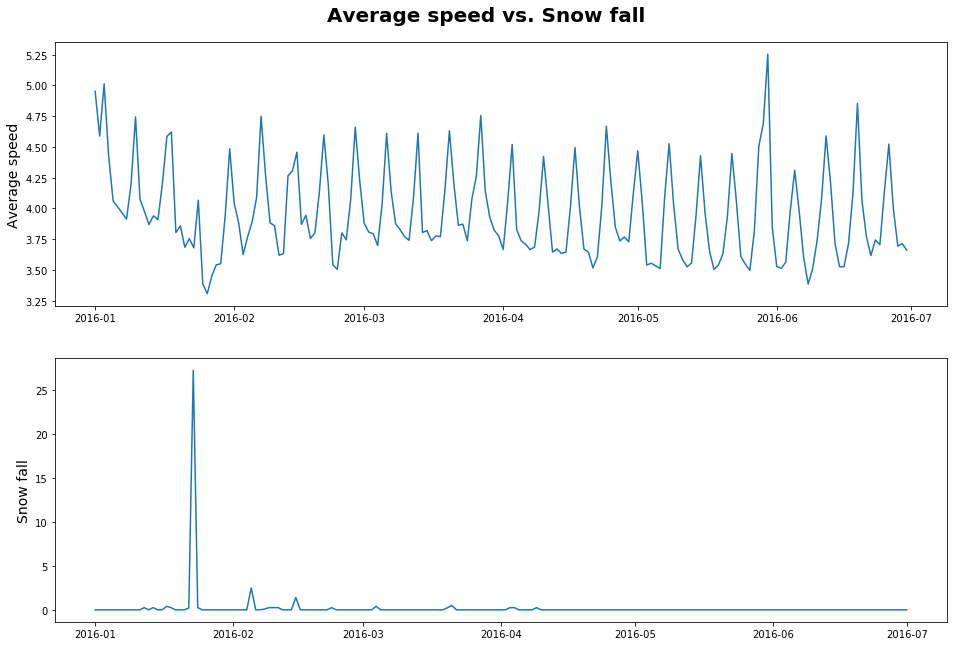

In [38]:
plt.suptitle('Average speed vs. Snow fall', fontsize=20, fontweight='bold')
plt.subplot(211)
plt.plot(df.groupby('pickup_date').mean()[['avg_speed_h']])
plt.ylabel('Average speed', fontsize = 14)

plt.subplot(212)
plt.plot(wdf.groupby('date').mean()[['snow_fall']])
plt.ylabel('Snow fall',fontsize = 14)
plt.subplots_adjust(top=0.93)
plt.show()

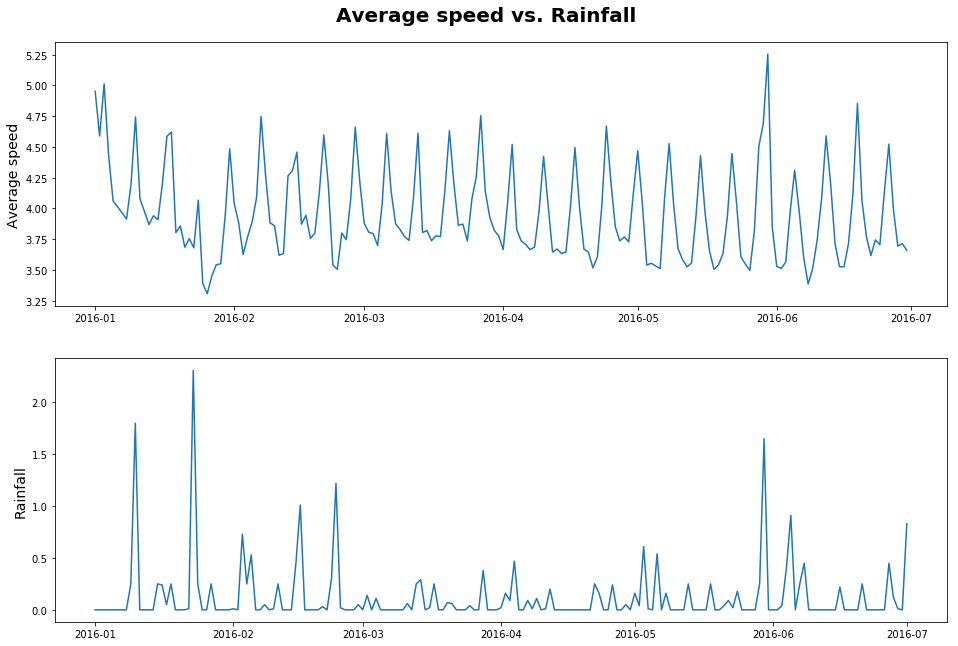

In [39]:
plt.suptitle('Average speed vs. Rainfall', fontsize=20, fontweight='bold')
plt.subplot(211)
plt.plot(df.groupby('pickup_date').mean()[['avg_speed_h']])
plt.ylabel('Average speed', fontsize = 14)

plt.subplot(212)
plt.plot(wdf.groupby('date').mean()[['precip']])
plt.ylabel('Rainfall',fontsize = 14)
plt.subplots_adjust(top=0.93)
plt.show()

- **Observations**

    1. The overall effect of all weather performed as expected, with most of the high snow depth or precipitation values coinciding with lower average speeds
    2. The peak in snow depth exactly corresponds to the day with least number of trips
    3. 3 dips below 7000 taxi rides: days before returning from the Winter Holiday Season, huge snowstorm in New York on January 23rd and Memorial Day Weekend when people do fun things out of the city
    4. "Icing effect": as snow stayed on ground for the first couple of days after snowfall, roads became icy and more difficult to traverse
    4. Memorial Day Weekend: less people were in the city so less taxi rides, less rides means taxis can travel faster
    5. Generally speaking, rain does not affect average speed of taxi rides